In [1]:
# Libraries 

import pandas as pd
import numpy as np
import csv
import os
import time
import pycountry as pcty
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import torch
import string
import nltk

from joblib import parallel_backend
from langdetect import detect
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import RobertaTokenizer, RobertaModel

from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix,accuracy_score, f1_score, roc_auc_score, recall_score, precision_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [2]:
# Define models
rfc = RandomForestClassifier()
#svc = SVC(kernel='linear', C=1, probability=True)
dtc = DecisionTreeClassifier()
sgd = SGDClassifier(loss='log', penalty='l2',random_state=1082)

In [3]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1082)

In [4]:
# Define evaluation metrics
scoring_weighted = ['accuracy', 'f1_weighted', 'roc_auc_ovr_weighted', 'recall_weighted', 'precision_weighted']

In [10]:
std_scaler = StandardScaler()

# RoBERTa

In [7]:
# ***** import roberta_dataset_ml instead of re-run the code ***** 
filename = 'roberta_dataset_ml.csv' 

if os.path.exists(filename):
    roberta_dataset = pd.read_csv(filename)

In [8]:
roberta_dataset

,hotelname_encode,comment_count,rating,location_rating,cleanliness_rating,service_rating,value_rating,contributes,helpfulvotes_guest,guest_rating_bubble,dateofStay_encode,guestCountry_encode,polarity_roberta
0,5,575,5.0,5.0,5.0,5.0,5.0,0.0,0.0,5.0,12023,105,positive
1,5,575,5.0,5.0,5.0,5.0,5.0,0.0,0.0,5.0,12023,105,positive
2,5,575,5.0,5.0,5.0,5.0,5.0,105.0,78.0,5.0,12023,123,positive
3,5,575,5.0,5.0,5.0,5.0,5.0,0.0,0.0,5.0,122022,105,positive
4,5,575,5.0,5.0,5.0,5.0,5.0,0.0,0.0,5.0,12023,105,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63547,4,946,4.0,4.5,4.0,4.0,4.0,0.0,0.0,1.0,82017,105,negative
63548,4,946,4.0,4.5,4.0,4.0,4.0,3.0,0.0,1.0,72017,105,negative
63549,4,946,4.0,4.5,4.0,4.0,4.0,81.0,43.0,5.0,32017,128,positive
63550,4,946,4.0,4.5,4.0,4.0,4.0,3726.0,160.0,3.0,72017,111,neutral


In [9]:
roberta_dataset.shape

(63552, 13)

In [10]:
# Encode polarity_roberta labels
label_map = {'negative': 0, 'positive': 1, 'neutral': 2}
roberta_dataset['polarity_roberta'] = roberta_dataset['polarity_roberta'].apply(lambda x: label_map[x])


In [56]:
roberta_dataset.describe()

,hotelname_encode,comment_count,rating,location_rating,cleanliness_rating,service_rating,value_rating,contributes,helpfulvotes_guest,guest_rating_bubble,dateofStay_encode,guestCountry_encode,polarity_roberta
count,63552.000000,63552.000000,63552.000000,63552.000000,63552.000000,63552.000000,63552.000000,63552.000000,63552.000000,63552.000000,63552.000000,63552.000000,63552.000000
mean,15.188240,4334.961952,4.434927,4.661860,4.496436,4.424833,4.316874,153.799330,59.897769,4.437516,70224.457075,92.646463,0.957610
std,7.072558,2474.014562,0.199788,0.365284,0.248073,0.232875,0.251954,1798.924116,981.571255,0.928108,35628.463587,38.771007,0.278179
min,0.000000,157.000000,4.000000,3.500000,4.000000,4.000000,4.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,9.000000,2860.000000,4.500000,4.500000,4.500000,4.500000,4.000000,4.000000,1.000000,4.000000,42013.000000,84.000000,1.000000
50%,14.000000,3844.000000,4.500000,4.500000,4.500000,4.500000,4.500000,25.000000,15.000000,5.000000,72017.000000,105.000000,1.000000
75%,20.000000,6421.000000,4.500000,5.000000,4.500000,4.500000,4.500000,91.000000,57.000000,5.000000,102016.000000,123.000000,1.000000
max,29.000000,8548.000000,5.000000,5.000000,5.000000,5.000000,5.000000,211962.000000,142971.000000,5.000000,122022.000000,149.000000,2.000000


In [69]:
#roberta_dataset.median(), roberta_dataset.mean()

summary= roberta_dataset.describe(include='all').loc[['mean', '50%'], :]
summary

,hotelname_encode,comment_count,rating,location_rating,cleanliness_rating,service_rating,value_rating,contributes,helpfulvotes_guest,guest_rating_bubble,dateofStay_encode,guestCountry_encode,polarity_roberta
mean,15.18824,4334.961952,4.434927,4.66186,4.496436,4.424833,4.316874,153.79933,59.897769,4.437516,70224.457075,92.646463,0.95761
50%,14.00000,3844.000000,4.500000,4.50000,4.500000,4.500000,4.500000,25.00000,15.000000,5.000000,72017.000000,105.000000,1.00000


In [58]:
numerical_val = [i for i in roberta_dataset.columns if roberta_dataset[i].dtypes != 'object']
numerical_df  = roberta_dataset[numerical_val]
numerical_df

,hotelname_encode,comment_count,rating,location_rating,cleanliness_rating,service_rating,value_rating,contributes,helpfulvotes_guest,guest_rating_bubble,dateofStay_encode,guestCountry_encode,polarity_roberta
0,5,575,5.0,5.0,5.0,5.0,5.0,0.0,0.0,5.0,12023,105,1
1,5,575,5.0,5.0,5.0,5.0,5.0,0.0,0.0,5.0,12023,105,1
2,5,575,5.0,5.0,5.0,5.0,5.0,105.0,78.0,5.0,12023,123,1
3,5,575,5.0,5.0,5.0,5.0,5.0,0.0,0.0,5.0,122022,105,1
4,5,575,5.0,5.0,5.0,5.0,5.0,0.0,0.0,5.0,12023,105,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63547,4,946,4.0,4.5,4.0,4.0,4.0,0.0,0.0,1.0,82017,105,0
63548,4,946,4.0,4.5,4.0,4.0,4.0,3.0,0.0,1.0,72017,105,0
63549,4,946,4.0,4.5,4.0,4.0,4.0,81.0,43.0,5.0,32017,128,1
63550,4,946,4.0,4.5,4.0,4.0,4.0,3726.0,160.0,3.0,72017,111,2


IndexError: list index out of range

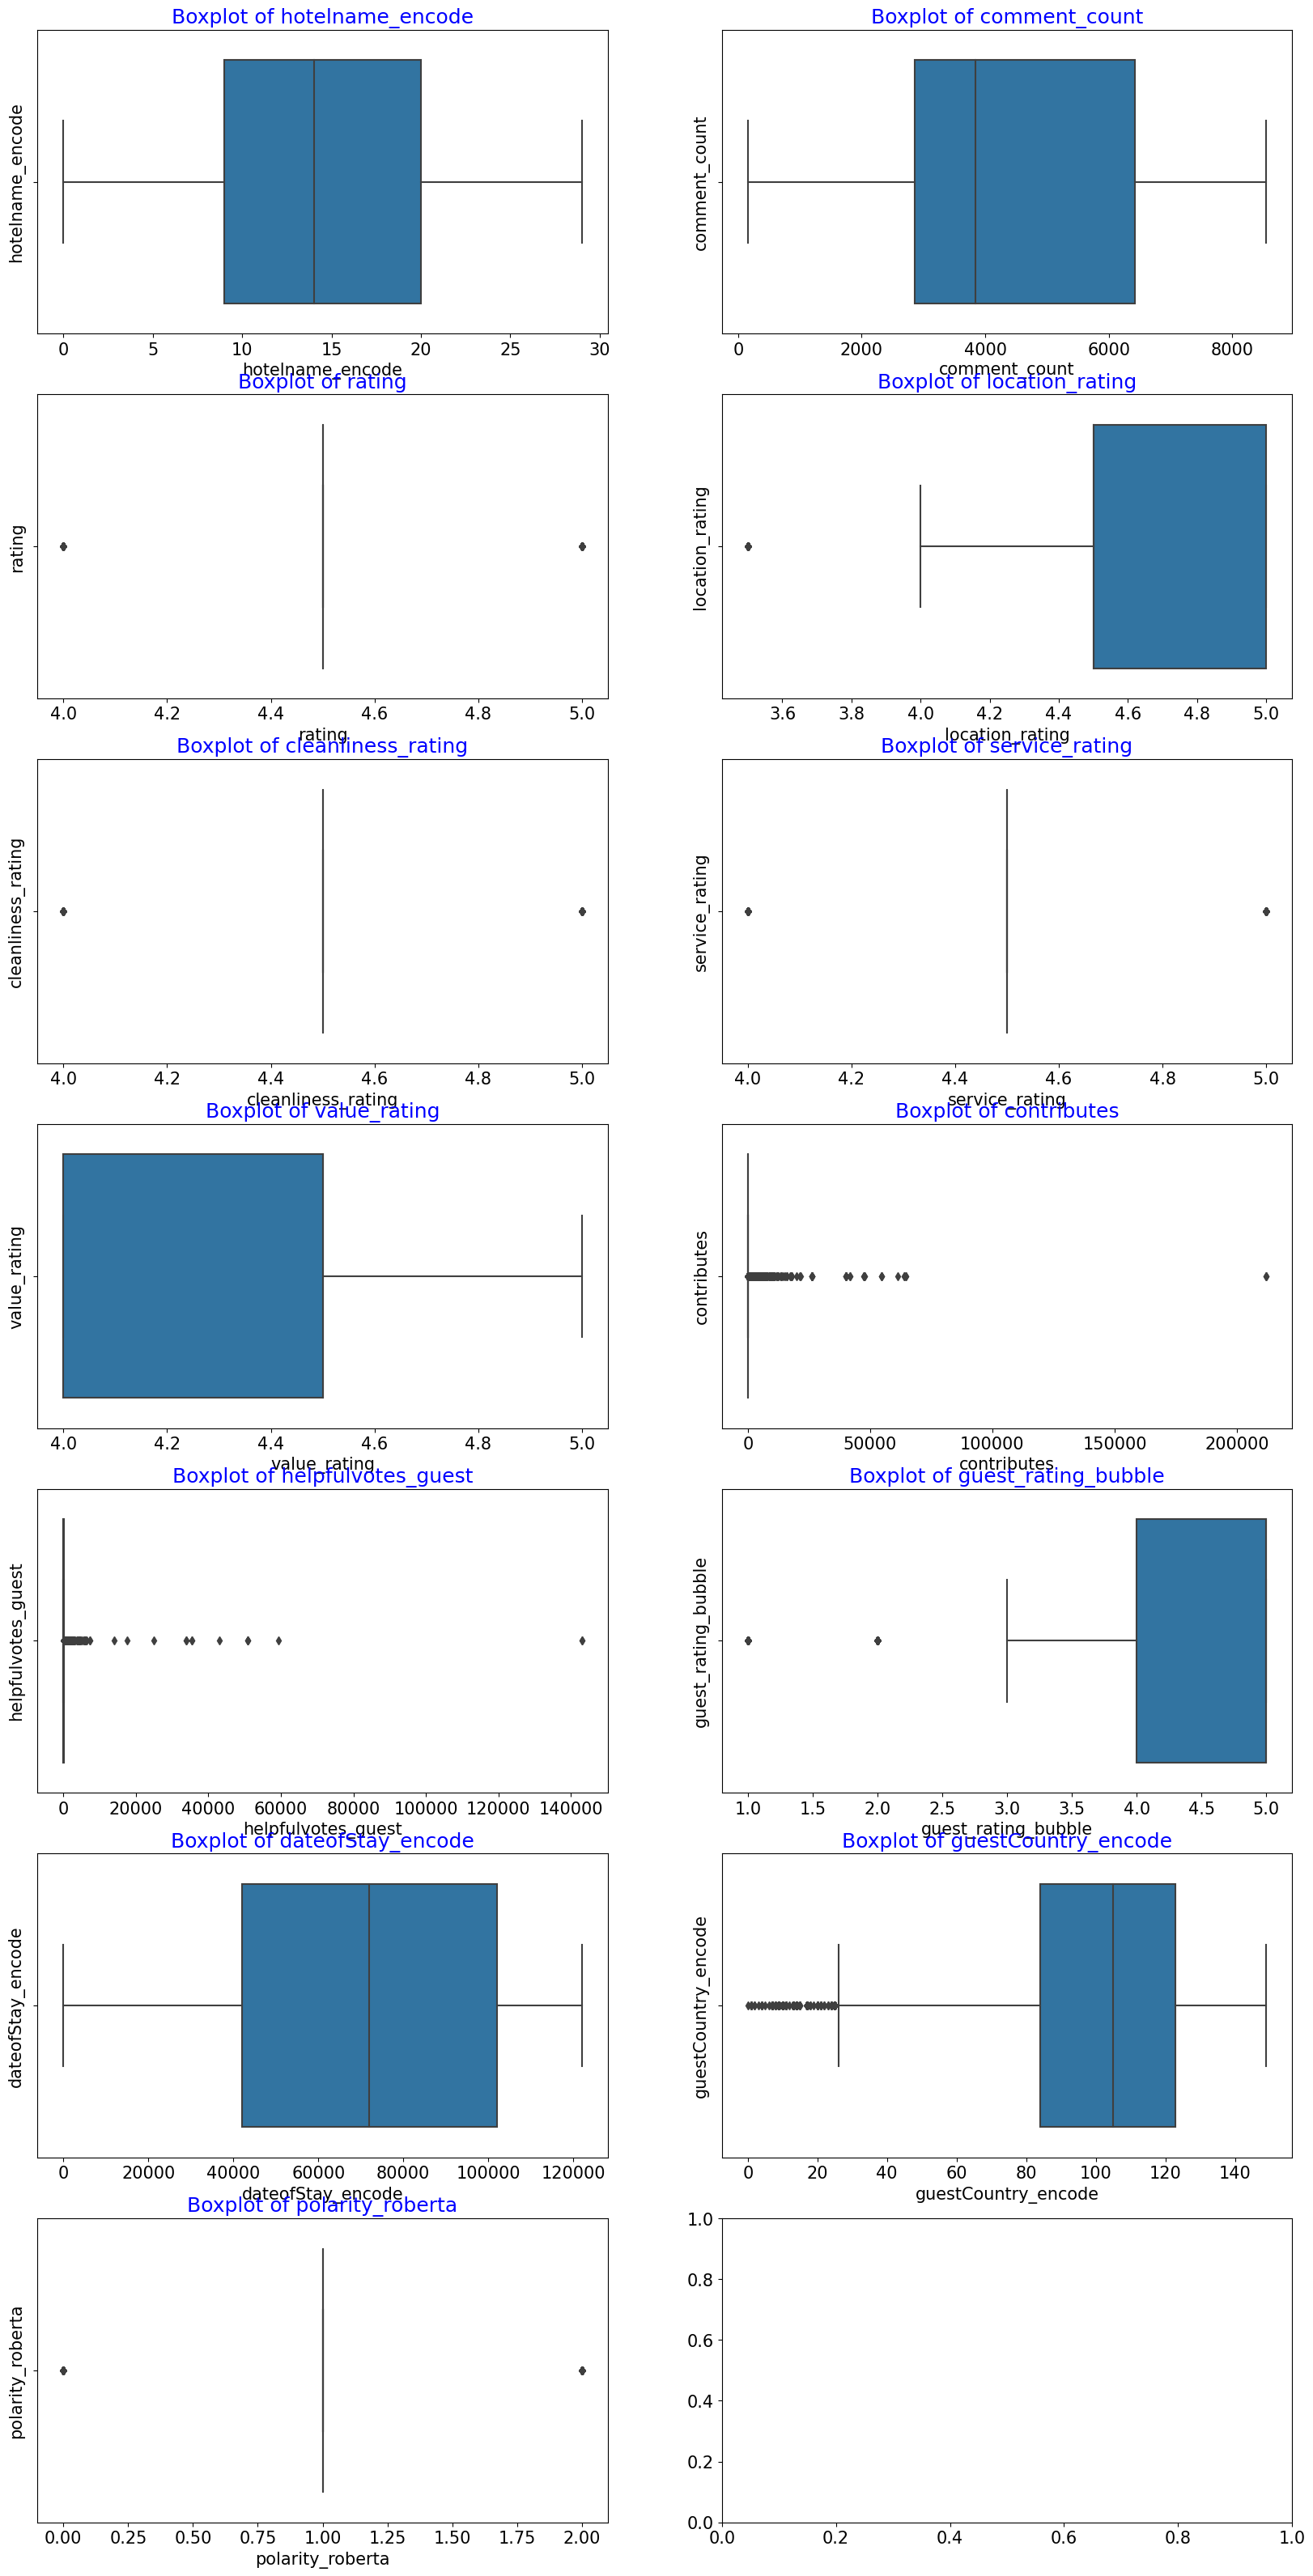

In [60]:
# Numerical attribute plots
plt.rcParams.update({'font.size': 15})

fig , ax = plt.subplots(7,2,figsize=(20,40))

numerical_var_count = 0

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        
        k = numerical_val[numerical_var_count]
        
        sns.boxplot(x=numerical_df[k], ax=ax[i,j])
        ax[i,j].set(xlabel=k, ylabel=k)
        ax[i,j].set_title('Boxplot of '+ k, color= 'blue')
        numerical_var_count = numerical_var_count + 1
        
plt.tight_layout()

In [11]:
# Split your data into input features (X) and target variable (y)
X = roberta_dataset.drop('polarity_roberta', axis=1)
y = roberta_dataset['polarity_roberta']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1082,stratify=y)

# Split the test set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1082,stratify=y_test)

# Print the number of records in each dataset
print("Number of records in X_train:", len(X_train))
print("Number of records in y_train:", len(y_train))
print("Number of records in X_val:", len(X_val))
print("Number of records in y_val:", len(y_val))
print("Number of records in X_test:", len(X_test))
print("Number of records in y_test:", len(y_test))


Number of records in X_train: 44486
Number of records in y_train: 44486
Number of records in X_val: 9533
Number of records in y_val: 9533
Number of records in X_test: 9533
Number of records in y_test: 9533


In [13]:

X_train_std = std_scaler.fit_transform(X_train)
X_val_std = std_scaler.transform(X_val)


In [15]:
X_train_std

array([[-0.17007591,  1.18688172,  0.32242106, ..., -1.54864646,
        -1.63878046,  0.31478672],
       [-0.45235238, -1.3176645 ,  2.82603828, ...,  0.60611424,
        -0.23519564, -0.2279595 ],
       [ 1.80585931, -0.25610825,  0.32242106, ...,  0.60611424,
        -0.51605298,  0.77999777],
       ...,
       [-1.15804353,  0.45751588,  0.32242106, ..., -0.47126611,
        -1.35826002, -1.59774758],
       [ 0.39447701,  0.14469987, -2.18119616, ...,  0.60611424,
         0.04549325,  1.27105387],
       [ 1.80585931, -0.25610825,  0.32242106, ..., -1.54864646,
        -1.35811964,  0.31478672]])

In [16]:
X_val_std

array([[ 0.53561524, -0.59273864,  0.32242106, ..., -1.54864646,
         1.16850147,  0.77999777],
       [ 0.53561524, -0.59273864,  0.32242106, ..., -0.47126611,
         0.60684295, -2.16633886],
       [ 1.38244462, -0.96650331,  0.32242106, ...,  0.60611424,
         1.44927458,  0.31478672],
       ...,
       [ 0.11220055, -1.05449543, -2.18119616, ..., -1.54864646,
        -1.63892083,  0.31478672],
       [ 1.80585931, -0.25610825,  0.32242106, ...,  0.60611424,
        -1.35826002,  0.31478672],
       [-0.87576707,  0.84460046,  0.32242106, ..., -1.54864646,
        -1.07757113,  0.31478672]])

In [17]:
X_train.head(5)

,hotelname_encode,comment_count,rating,location_rating,cleanliness_rating,service_rating,value_rating,contributes,helpfulvotes_guest,guest_rating_bubble,dateofStay_encode,guestCountry_encode
31562,14,7269,4.5,5.0,4.5,4.5,4.5,3.0,0.0,3.0,12022,105
1135,12,1064,5.0,5.0,5.0,4.5,4.5,2.0,2.0,5.0,62017,84
43709,28,3694,4.5,5.0,4.5,4.5,4.0,5.0,8.0,5.0,52013,123
34120,14,7269,4.5,5.0,4.5,4.5,4.5,1.0,0.0,5.0,72016,105
37880,27,670,4.5,4.0,4.5,4.5,4.5,598.0,143.0,4.0,62016,80


In [18]:
y_train.head(5)

31562    0
1135     1
43709    1
34120    1
37880    1
Name: polarity_roberta, dtype: int64

In [19]:
from sklearn.utils.class_weight import compute_sample_weight

# Calculate sample weights for the validation data
sample_weights_valid = compute_sample_weight(class_weight='balanced', y=y_val)


## Random Forest

In [20]:
# Evaluate models using cross-validation
rfc_scores_weighted = cross_validate(rfc, X_train_std, y_train, cv=cv, scoring=scoring_weighted,return_train_score=True, error_score=1, fit_params=None, n_jobs=-1)

In [21]:
# kfold stratified - RF
# Get mean scores of each metric for each model
rfc_mean_scores_weighted = {metric: scores.mean() for metric, scores in rfc_scores_weighted.items()}
print("Random Forest Classifier (Stratified):")
print(rfc_mean_scores_weighted )
print()


Random Forest Classifier (Stratified):
{'fit_time': 4.3347193717956545, 'score_time': 0.3531468391418457, 'test_accuracy': 0.9407453847386513, 'train_accuracy': 0.9989491078053504, 'test_f1_weighted': 0.931605928986782, 'train_f1_weighted': 0.9989462483588196, 'test_roc_auc_ovr_weighted': 0.9102311195525499, 'train_roc_auc_ovr_weighted': 0.9999426041277533, 'test_recall_weighted': 0.9407453847386513, 'train_recall_weighted': 0.9989491078053504, 'test_precision_weighted': 0.9253375963008038, 'train_precision_weighted': 0.9989479489409234}



## SVM with stochastic gradient descent (SGD) learning

In [22]:
start_time = time.time()
sgd_scores = cross_validate(sgd, X_train_std, y_train, cv=cv, scoring=scoring_weighted, return_train_score=True, error_score=1, fit_params=None, n_jobs=-1, verbose=0, pre_dispatch='2*n_jobs')

end_time = time.time()
time_taken = end_time - start_time
print(f"\n\n Time taken: {time_taken} seconds")



 Time taken: 2.7764523029327393 seconds


In [23]:
sgd_mean_scores = {metric: scores.mean() for metric, scores in sgd_scores.items()}
print("SVM with SGD (Stratified):")
print(sgd_mean_scores)


SVM with SGD (Stratified):
{'fit_time': 0.3483370304107666, 'score_time': 0.06307048797607422, 'test_accuracy': 0.9452187219014302, 'train_accuracy': 0.9448983981519208, 'test_f1_weighted': 0.9347359298688153, 'train_f1_weighted': 0.9343941184985771, 'test_roc_auc_ovr_weighted': 0.9234987651192499, 'train_roc_auc_ovr_weighted': 0.9237642541828303, 'test_recall_weighted': 0.9452187219014302, 'train_recall_weighted': 0.9448983981519208, 'test_precision_weighted': 0.925215845455457, 'train_precision_weighted': 0.9248084593503176}


In [80]:
sgd_mean_scores = {metric: scores.mean() for metric, scores in sgd_scores.items()}
print("SVM with SGD (Stratified):")
print(sgd_mean_scores)


SVM with SGD (Stratified):
{'fit_time': 9.55301365852356, 'score_time': 0.035049724578857425, 'test_accuracy': 0.9365871469324027, 'train_accuracy': 0.936586702406961, 'test_f1_weighted': 0.906253856832571, 'train_f1_weighted': 0.9062639821640504, 'test_roc_auc_ovr_weighted': 0.6065559915842766, 'train_roc_auc_ovr_weighted': 0.6067337213615536, 'test_recall_weighted': 0.9365871469324027, 'train_recall_weighted': 0.936586702406961, 'test_precision_weighted': 0.8783200583775714, 'train_precision_weighted': 0.8783391147670964}


## Decision Tree

In [24]:
dtc_scores = cross_validate(dtc, X_train_std, y_train, cv=cv, scoring=scoring_weighted,return_train_score=True, error_score=1, fit_params=None, n_jobs=-1)
dtc_mean_scores = {metric: scores.mean() for metric, scores in dtc_scores.items()}

In [25]:
#kfold stratified
print("Decision Tree Classifier (stratified):")
print(dtc_mean_scores)
print()


Decision Tree Classifier (stratified):
{'fit_time': 0.1839667320251465, 'score_time': 0.018414306640625, 'test_accuracy': 0.90860053872453, 'train_accuracy': 0.9989828264049105, 'test_f1_weighted': 0.9107387342205664, 'train_f1_weighted': 0.9989813738322872, 'test_roc_auc_ovr_weighted': 0.7331084035182597, 'train_roc_auc_ovr_weighted': 0.9999930236325134, 'test_recall_weighted': 0.90860053872453, 'train_recall_weighted': 0.9989828264049105, 'test_precision_weighted': 0.9129697205181702, 'train_precision_weighted': 0.9989856053589434}



In [82]:
#kfold stratified
print("Decision Tree Classifier (stratified):")
print(dtc_mean_scores)
print()


Decision Tree Classifier (stratified):
{'fit_time': 0.24285202026367186, 'score_time': 0.032891368865966795, 'test_accuracy': 0.9075889819993066, 'train_accuracy': 0.9989828264049105, 'test_f1_weighted': 0.909967540016914, 'train_f1_weighted': 0.9989813738322872, 'test_roc_auc_ovr_weighted': 0.7308360743791928, 'train_roc_auc_ovr_weighted': 0.9999930236325134, 'test_recall_weighted': 0.9075889819993066, 'train_recall_weighted': 0.9989828264049105, 'test_precision_weighted': 0.9124616876590276, 'train_precision_weighted': 0.9989856053589434}



### Best model of RoBERTa

In [37]:
print("RoBERTa:")
# Get best model based on mean accuracy score
models = {"Random Forest Classifier": rfc_mean_scores_weighted,
          "Support Vector Machine": sgd_mean_scores,
          "Decision Tree Classifier": dtc_mean_scores}

best_model = max(models, key=lambda k: models[k]['test_accuracy'])
print(f"The best model is {best_model} with a test accuracy of {models[best_model]['test_accuracy']}")


RoBERTa:
The best model is Random Forest Classifier with a test accuracy of 0.9402508587515376


# Vader

In [5]:
# ***** import vader_dataset instead of re-run the code ***** skip the below code if the section
filename = 'vader_dataset_ml.csv' 

if os.path.exists(filename):
    vader_dataset = pd.read_csv(filename)

In [6]:
# Encode polarity_vader labels
label_map = {'negative': 0, 'positive': 1, 'neutral': 2}
vader_dataset['polarity_vader'] = vader_dataset['polarity_vader'].apply(lambda x: label_map[x])


In [7]:
vader_dataset

,hotelname_encode,comment_count,rating,location_rating,cleanliness_rating,service_rating,value_rating,contributes,helpfulvotes_guest,guest_rating_bubble,dateofStay_encode,guestCountry_encode,polarity_vader
0,5,575,5.0,5.0,5.0,5.0,5.0,0.0,0.0,5.0,12023,105,1
1,5,575,5.0,5.0,5.0,5.0,5.0,0.0,0.0,5.0,12023,105,1
2,5,575,5.0,5.0,5.0,5.0,5.0,105.0,78.0,5.0,12023,123,1
3,5,575,5.0,5.0,5.0,5.0,5.0,0.0,0.0,5.0,122022,105,1
4,5,575,5.0,5.0,5.0,5.0,5.0,0.0,0.0,5.0,12023,105,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63547,4,946,4.0,4.5,4.0,4.0,4.0,0.0,0.0,1.0,82017,105,0
63548,4,946,4.0,4.5,4.0,4.0,4.0,3.0,0.0,1.0,72017,105,0
63549,4,946,4.0,4.5,4.0,4.0,4.0,81.0,43.0,5.0,32017,128,1
63550,4,946,4.0,4.5,4.0,4.0,4.0,3726.0,160.0,3.0,72017,111,1


In [8]:
# Split your data into input features (X) and target variable (y)
X = vader_dataset.drop('polarity_vader', axis=1)
y = vader_dataset['polarity_vader']

# Split data into training and test sets
X_train_vader, X_test_vader, y_train_vader, y_test_vader = train_test_split(X, y, test_size=0.3, random_state=1082,stratify=y)

# Split the test set into validation and test sets
X_val_vader, X_test_vader, y_val_vader, y_test_vader = train_test_split(X_test_vader, y_test_vader, test_size=0.5, random_state=1082,stratify=y_test_vader)

# Print the number of records in each dataset
print("Number of records in X_train_vader:", len(X_train_vader))
print("Number of records in y_train_vader:", len(y_train_vader))
print("Number of records in X_val_vader:", len(X_val_vader))
print("Number of records in y_val_vader:", len(y_val_vader))
print("Number of records in X_test_vader:", len(X_test_vader))
print("Number of records in y_test_vader:", len(y_test_vader))


Number of records in X_train_vader: 44486
Number of records in y_train_vader: 44486
Number of records in X_val_vader: 9533
Number of records in y_val_vader: 9533
Number of records in X_test_vader: 9533
Number of records in y_test_vader: 9533


In [11]:
X_train_vader_std = std_scaler.fit_transform(X_train_vader)
X_val_vader_std = std_scaler.transform(X_val_vader)

### Random Forest

In [33]:
# Evaluate models using cross-validation
rfc_scores_vader = cross_validate(rfc, X_train_vader_std, y_train_vader, cv=cv, scoring=scoring_weighted,return_train_score=True, error_score=1, fit_params=None, n_jobs=-1)

# Get mean scores of each metric for each model
rfc_mean_scores_vader = {metric: scores.mean() for metric, scores in rfc_scores_vader.items()}

In [34]:
print("VADER:")
print("Random Forest Classifier (Stratified):")
print(rfc_mean_scores_vader)
print()

VADER:
Random Forest Classifier (Stratified):
{'fit_time': 3.608148384094238, 'score_time': 0.3177584171295166, 'test_accuracy': 0.9600997813365837, 'train_accuracy': 0.9994380256040472, 'test_f1_weighted': 0.95354261541194, 'train_f1_weighted': 0.9994368975327248, 'test_roc_auc_ovr_weighted': 0.897956644565423, 'train_roc_auc_ovr_weighted': 0.9999805554182242, 'test_recall_weighted': 0.9600997813365837, 'train_recall_weighted': 0.9994380256040472, 'test_precision_weighted': 0.9495746079517954, 'train_precision_weighted': 0.9994373757377947}



### SVM with SGD

In [12]:
start_time = time.time()
sgd_scores_vader = cross_validate(sgd, X_train_vader_std, y_train_vader, cv=cv, scoring=scoring_weighted, return_train_score=True, error_score=1, fit_params=None, n_jobs=-1, verbose=0, pre_dispatch='2*n_jobs')

end_time = time.time()
time_taken = end_time - start_time
print(f"\n\n Time taken: {time_taken} seconds")



 Time taken: 7.343828916549683 seconds


In [36]:
sgd_mean_scores_vader = {metric: scores.mean() for metric, scores in sgd_scores_vader.items()}
print("SVM with SGD (Stratified):")
print(sgd_mean_scores_vader)


SVM with SGD (Stratified):
{'fit_time': 0.3344024658203125, 'score_time': 0.027429771423339844, 'test_accuracy': 0.9618756204248855, 'train_accuracy': 0.9617126724767637, 'test_f1_weighted': 0.9564431157645691, 'train_f1_weighted': 0.956306075169772, 'test_roc_auc_ovr_weighted': 0.9200810128141985, 'train_roc_auc_ovr_weighted': 0.9216921874264248, 'test_recall_weighted': 0.9618756204248855, 'train_recall_weighted': 0.9617126724767637, 'test_precision_weighted': 0.9527661520701933, 'train_precision_weighted': 0.9525991084030991}


In [13]:
sgd.fit(X_train_vader_std, y_train_vader)
#vader_sgd_y_pred = sgd.predict(X_val_vader)

C:\Users\guimi\AppData\Local\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


SGDClassifier(loss='log', random_state=1082)

### Decision Tree

In [37]:
# Evaluate models using cross-validation
dtc_scores_vader = cross_validate(dtc, X_train_vader_std, y_train_vader, cv=cv, scoring=scoring_weighted,return_train_score=True, error_score=1, fit_params=None, n_jobs=-1)

# Get mean scores of each metric for each model
dtc_mean_scores_vader = {metric: scores.mean() for metric, scores in dtc_scores_vader.items()}


In [38]:
#kfold stratified
print("VADER:")
print("Decision Tree Classifier (stratified):")
print(dtc_mean_scores_vader)
print()

VADER:
Decision Tree Classifier (stratified):
{'fit_time': 0.15832576751708985, 'score_time': 0.0176363468170166, 'test_accuracy': 0.9416445389738304, 'train_accuracy': 0.999471744045697, 'test_f1_weighted': 0.9430687204237582, 'train_f1_weighted': 0.9994724335373684, 'test_roc_auc_ovr_weighted': 0.6568489794186922, 'train_roc_auc_ovr_weighted': 0.9999960742069589, 'test_recall_weighted': 0.9416445389738304, 'train_recall_weighted': 0.999471744045697, 'test_precision_weighted': 0.9445490270712688, 'train_precision_weighted': 0.9994743015991144}



### Best model of VADER

In [52]:

# Get best model based on mean accuracy score
models_vader = {"Random Forest Classifier": rfc_mean_scores_vader,
          "Support Vector Machine": sgd_mean_scores_vader,
          "Decision Tree Classifier": dtc_mean_scores_vader}

best_model_vader = max(models_vader, key=lambda k: models_vader[k]['test_accuracy'])
print(f"The best model is {best_model_vader} with a test accuracy of {models_vader[best_model_vader]['test_accuracy']}")


The best model is Support Vector Machine with a test accuracy of 0.967450616686515


## Result Comparison

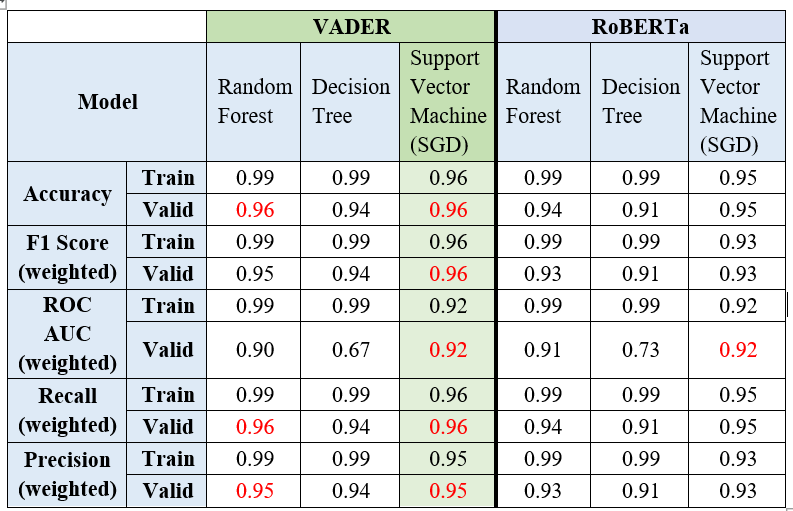

# Model Reliability Test

In [ ]:
# X_test_vader, y_test_vader

In [15]:
X_test_vader_std = std_scaler.fit_transform(X_test_vader)


In [45]:
sgd.fit(X_train_vader_std, y_train_vader)


C:\Users\guimi\AppData\Local\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\guimi\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(


#### val data

In [51]:
y_pred_val_vader = sgd.predict(X_val_vader_std)

In [54]:
# Calculate evaluation metrics
vader_sgd_val_acc = accuracy_score(y_val_vader, y_pred_val_vader)
vader_sgd_val_f1 = f1_score(y_val_vader, y_pred_val_vader, average='weighted')
vader_sgd_val_roc_auc = roc_auc_score(y_val_vader, sgd.predict_proba(X_val_vader_std), multi_class='ovr')
vader_sgd_val_recall = recall_score(y_val_vader, y_pred_val_vader, average='weighted')
vader_sgd_val_precision = precision_score(y_val_vader, y_pred_val_vader, average='weighted')

print("VADER - Support Vector Machine with SGD - Val data:")
print(f"Validation Accuracy: {vader_sgd_val_acc}")
print(f"Validation F1 Score: {vader_sgd_val_f1}")
print(f"Validation ROC AUC Score: {vader_sgd_val_roc_auc}")
print(f"Validation Recall Score: {vader_sgd_val_recall}")
print(f"Validation Precision Score: {vader_sgd_val_precision}")

VADER - Support Vector Machine with SGD - Val data:
Validation Accuracy: 0.9610825553341026
Validation F1 Score: 0.9559710337603081
Validation ROC AUC Score: 0.8985876850044149
Validation Recall Score: 0.9610825553341026
Validation Precision Score: 0.9522245585425975


C:\Users\guimi\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### test data

In [16]:
y_pred_test_vader = sgd.predict(X_test_vader_std)

In [52]:
# Calculate evaluation metrics
vader_sgd_test_acc = accuracy_score(y_test_vader, y_pred_test_vader)
vader_sgd_test_f1 = f1_score(y_test_vader, y_pred_test_vader, average='weighted')
vader_sgd_test_roc_auc = roc_auc_score(y_test_vader, sgd.predict_proba(X_test_vader_std), multi_class='ovr')
vader_sgd_test_recall = recall_score(y_test_vader, y_pred_test_vader, average='weighted')
vader_sgd_test_precision = precision_score(y_test_vader, y_pred_test_vader, average='weighted')


C:\Users\guimi\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
print("VADER - Support Vector Machine with SGD - TEST data:")
print(f"Validation Accuracy: {vader_sgd_test_acc}")
print(f"Validation F1 Score: {vader_sgd_test_f1}")
print(f"Validation ROC AUC Score: {vader_sgd_test_roc_auc}")
print(f"Validation Recall Score: {vader_sgd_test_recall}")
print(f"Validation Precision Score: {vader_sgd_test_precision}")


VADER - Support Vector Machine with SGD - TEST data:
Validation Accuracy: 0.9605580614706808
Validation F1 Score: 0.9550886543062024
Validation ROC AUC Score: 0.8459725587800735
Validation Recall Score: 0.9605580614706808
Validation Precision Score: 0.9511861135464676


In [26]:
# Convert the predicted values numpy array to a DataFrame
y_pred_test_vader_df = pd.DataFrame(y_pred_test_vader, columns=['predicted_target'])
y_pred_test_vader_df


,predicted_target
0,1
1,1
2,1
3,1
4,1
...,...
9528,1
9529,1
9530,1
9531,1


In [28]:
# Concatenate the predicted values DataFrame with the x_test DataFrame
x_test_with_predictions = pd.concat([X_test_vader,y_pred_test_vader_df], axis=1)

In [29]:
x_test_with_predictions

,hotelname_encode,comment_count,rating,location_rating,cleanliness_rating,service_rating,value_rating,contributes,helpfulvotes_guest,guest_rating_bubble,dateofStay_encode,guestCountry_encode,predicted_target
23615,20.0,8548.0,4.5,4.5,4.5,4.5,4.5,2.0,2.0,4.0,12015.0,111.0,NaN
3768,9.0,6421.0,4.5,4.5,4.5,4.5,4.5,6.0,8.0,5.0,62018.0,142.0,1.0
18101,7.0,5462.0,4.5,5.0,4.5,4.5,4.5,154.0,103.0,5.0,72016.0,9.0,NaN
46490,11.0,3536.0,4.5,5.0,4.5,4.5,4.0,2.0,3.0,5.0,12015.0,141.0,NaN
31450,14.0,7269.0,4.5,5.0,4.5,4.5,4.5,1.0,0.0,5.0,72022.0,105.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
